# BÁO CÁO CUỐI KỲ
Thành viên: 
- Huỳnh Ngọc Thuật
- Đoàn Tân Tỵ
- Hường Lê Nguyên

## I.Phát biểu bài toán

Dataset chứa tất cả thông tin của các Pokemon trong một series phim hoạt hình Pokémon khá nổi tiếng.
Dữ liệu được nhóm crawl từ trang https://pokemondb.net/pokedex/all chứa thông tin về chỉ số cơ bản của mỗi pokemon

- Mục tiêu của bài toán: Thứ nhất là phân nhóm các con pokemon dựa trên 6 loại chỉ số là HP, Attack, Defense, SP Attack, SP Defense, Speed -> Từ đó tìm ra những con linh thú có chỉ số tốt nhất trong toàn bộ dataset. Thứ hai là tìm ra những pokemon thay thế phù hợp nhất những pokemon đầu tiên đi cùng Satoshi gồm 5 con là Bulbasaur, Charizard, Squirtle, Pikachu, Pidgeotto.
- Thuật toán sử dụng: Kmeans Clustering, Hierarchical Clustering, DBSCAN Clustering

In [31]:
from IPython.display import Image, display
Image(url= "./image.jfif", width=400, height=400)


## II.Các bước triển khai

### 1. Import các thư viện cần thiết

In [32]:
import numpy as np
import pandas as pd
import matplotlib
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# matplotlib.use('nbagg')
warnings.filterwarnings("ignore")
# sns.set()

### 2. Đọc dữ liệu pokemon từ file csv

In [33]:
df = pd.read_csv('pokemon.csv', encoding='latin-1')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Code        1075 non-null   int64 
 1   Name        1075 non-null   object
 2   Type 1      1075 non-null   object
 3   Type 2      580 non-null    object
 4   Total       1075 non-null   int64 
 5   HP          1075 non-null   int64 
 6   Attack      1075 non-null   int64 
 7   Defense     1075 non-null   int64 
 8   SP Attack   1075 non-null   int64 
 9   SP Defense  1075 non-null   int64 
 10  Speed       1075 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 92.5+ KB


,Code,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP Attack,SP Defense,Speed
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,3,Venusaur-Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65


### 3. Phân tích khám phá dữ liệu(Exploraty Data Analysis)

Quan sát tự tương quan giữa các trường trong dữ liệu

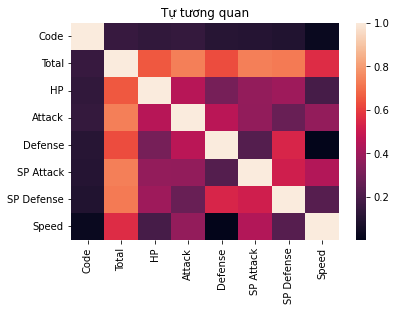

In [34]:
sns.heatmap(df.corr())
plt.title('Tự tương quan')
plt.show()

Sự phân bố của dữ liệu

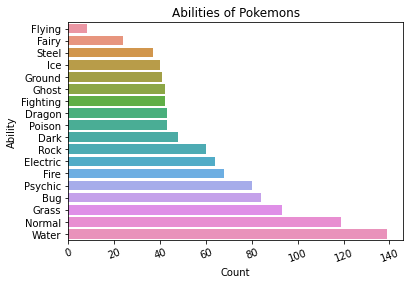

In [35]:
# Phân bố theo hệ của pokemon
count_ability = df.groupby('Type 1').count().reset_index().sort_values(by='Total', ascending=True)
sns.barplot(x='Total',y='Type 1',data=count_ability)
plt.xticks(rotation=20)
plt.title("Abilities of Pokemons")
plt.xlabel("Count")
plt.ylabel("Ability")
plt.show()

Sự tương quan của các chỉ số thông qua hệ chính của pokemon(Type 1)

Pairplot segregated on type


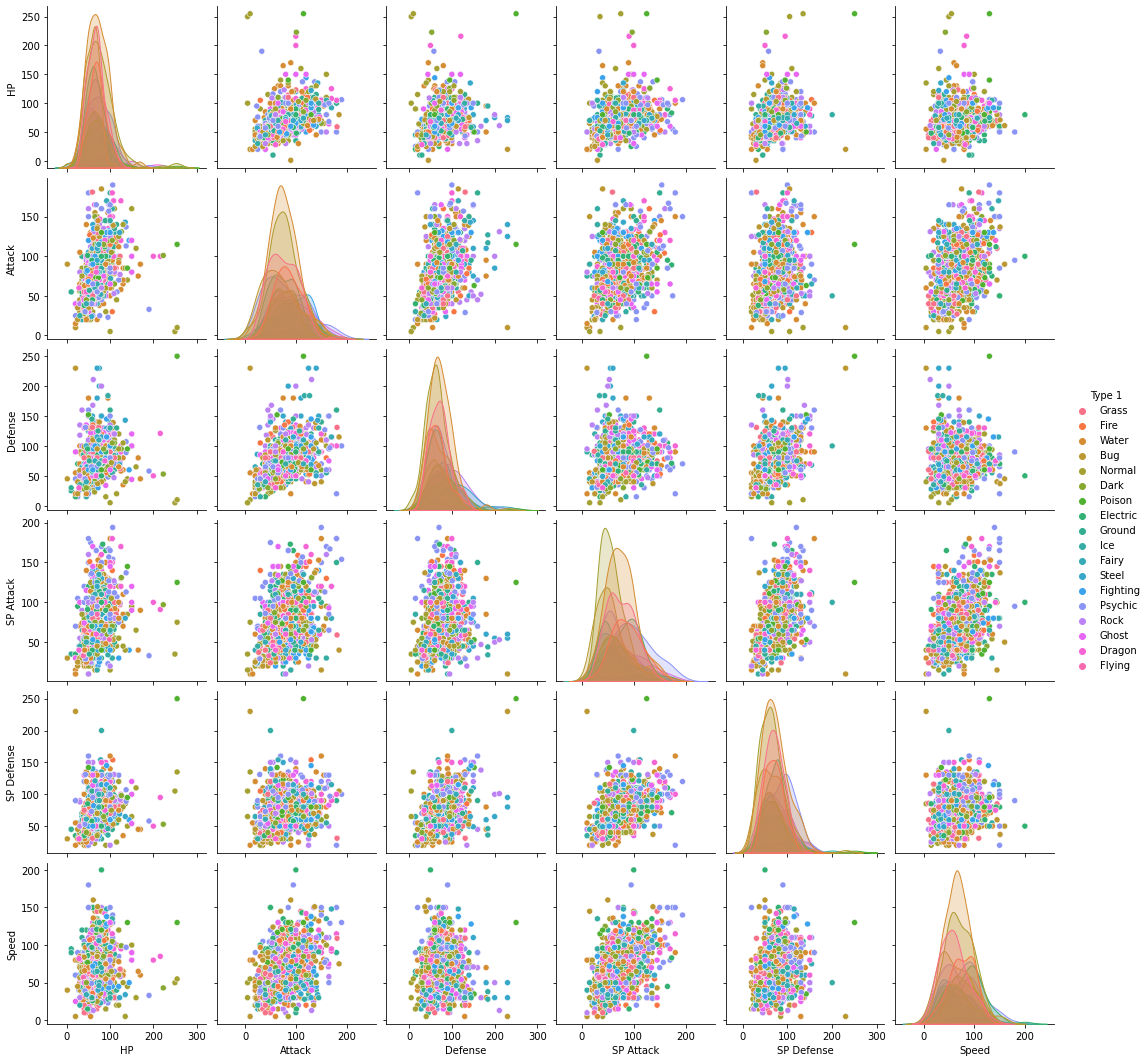

In [36]:
sns.pairplot(data=df[['HP','Attack','Defense','SP Attack','SP Defense','Speed','Type 1']], hue='Type 1')
print('Pairplot segregated on type')
plt.show()

Xem sự tương quan giữa hệ chính và hệ phụ của một pokemon

Text(0.5, 1.0, 'Sự tương quan giữa hệ chính và hệ phụ')

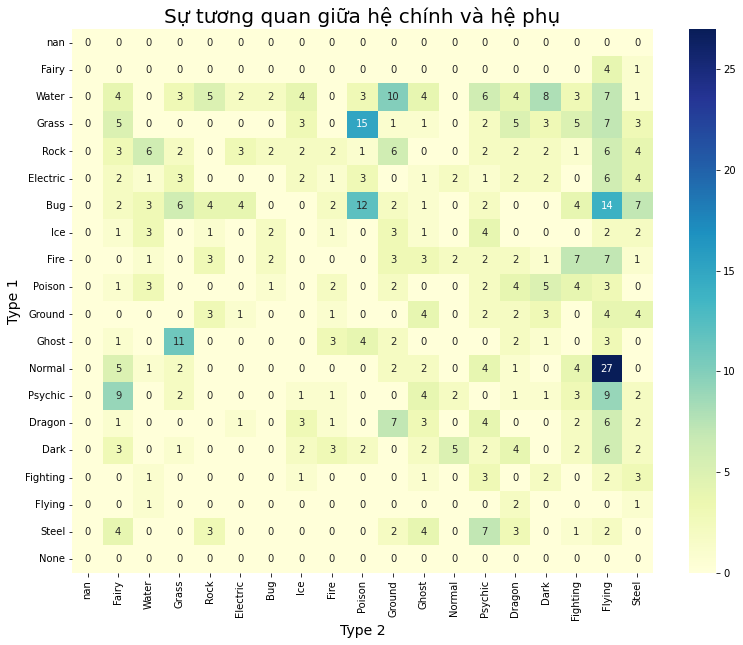

In [37]:
pokemon_types=list(set(df["Type 1"]).union(set(df["Type 2"]))-{"None"})+["None"]

dummy_type_1=pd.get_dummies(df["Type 1"])
dummy_type_2=pd.get_dummies(df["Type 2"])
for poke_type in pokemon_types:
    if poke_type not in dummy_type_1.columns:
        dummy_type_1[poke_type]=0
    if poke_type not in dummy_type_2.columns:
        dummy_type_2[poke_type]=0
heat_df=np.matmul(dummy_type_1[pokemon_types].T,dummy_type_2[pokemon_types])
heat_df.columns=pokemon_types
# I only consider cooccurences...
heat_df.drop(columns=["None"],inplace=True)

plt.figure(figsize=(13,10))
ax = sns.heatmap(heat_df,cmap="YlGnBu",annot=True)
plt.xlabel("Type 2", fontsize=14)
plt.ylabel("Type 1", fontsize=14)
plt.title("Sự tương quan giữa hệ chính và hệ phụ", fontsize=20)

### 4. Xử lý dữ liệu

#### 4.1 Xử lý dữ liệu trống
- Dữ liệu trống chỉ có ở trường 'Type 2' không ảnh hưởng tới bài toán nên không cần phải xử lý

In [38]:
df.isnull().sum()

Code            0
Name            0
Type 1          0
Type 2        495
Total           0
HP              0
Attack          0
Defense         0
SP Attack       0
SP Defense      0
Speed           0
dtype: int64

#### 4.2 Xử lý ngoại lệ

Text(0.5, 0, 'Attributes')

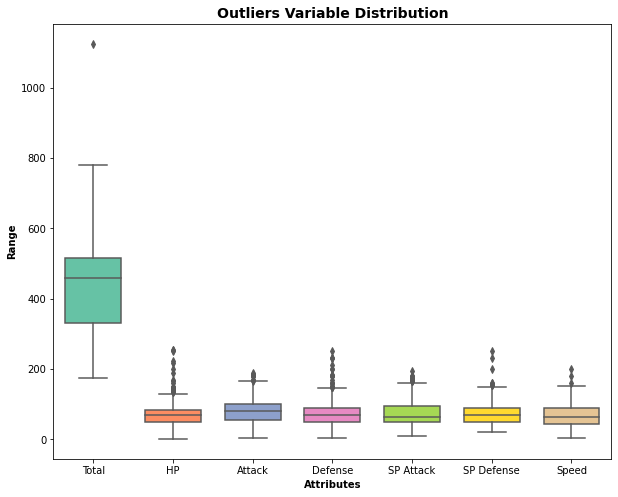

In [39]:
attributes = ['Total', 'HP', 'Attack', 'Defense', 'SP Attack', 'SP Defense', 'Speed']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Không xử lý

#### 4.3 Chuẩn hoá dữ liệu để giảm bớt sự ảnh hưởng của dữ liệu lớn

##### 4.3.1 Chuẩn hóa dữ liệu

In [40]:
min_max = MinMaxScaler()
df_converted = df[['Total', 'HP', 'Attack', 'Defense', 'SP Attack', 'SP Defense', 'Speed']]
df_MinMax = pd.DataFrame(min_max.fit_transform(df_converted), columns=df_converted.columns)
df_MinMax.head()


,Total,HP,Attack,Defense,SP Attack,SP Defense,Speed
0,0.150526,0.173228,0.237838,0.179592,0.298913,0.195652,0.205128
1,0.242105,0.232283,0.308108,0.236735,0.380435,0.260870,0.282051
2,0.368421,0.311024,0.416216,0.318367,0.489130,0.347826,0.384615
3,0.473684,0.311024,0.513514,0.481633,0.608696,0.434783,0.384615
4,0.141053,0.149606,0.254054,0.155102,0.271739,0.130435,0.307692


##### 4.3.2 Giảm chiều dữ liệu

In [41]:
def PCA_DF(df, nComponents):
    pca = PCA(
        n_components=nComponents,
        random_state=11,
        whiten=True
    )
    pca = pca.fit_transform(df)
    return pca

df_PCA = PCA_DF(df_MinMax, 3);
print(df_PCA)

[[-0.94413583 -0.42284437  0.61949003]
 [-0.26831302 -0.43388717  0.66921541]
 [ 0.66939768 -0.3876631   0.68986616]
 ...
 [ 0.54036402  0.72089277 -1.06121389]
 [ 1.41877336 -1.13927525 -0.28705005]
 [ 1.28775815  0.51789365  1.38192106]]


Các hàm vẽ 2d và 3d

In [ ]:
def plot_3D(data, title):
    fig = plt.figure(figsize=(20, 8), dpi=100)
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data['Nearest Purchase'], 
                data['Total Purchased'], 
                data['Frequency'],
                c = data['Clusters'], 
                cmap ='rainbow')

    ax.set_xlabel('Nearest Purchase')
    ax.set_ylabel('Total Purchase')
    ax.set_zlabel('Frequency')
    ax.set_title(title)

def plot_2D(X, labels):
    # Chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int)])

    # Thêm nhãn cho mỗi cụm
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('T-SNE visualization')


### 5. MÔ HÌNH
- Gồm: KMeans, DBScan, Hierarchical 

#### 5.1 Chọn k

##### 5.1.1 Elbow method (KMeans)

Chọn số cụm thích hợp - Phương pháp elbow method
- Chúng ta sẽ sử dụng thuộc tính tích hợp trong sklearn 'inertia_'
- 'inertia_' - Tổng bình phương khoảng cách đến mỗi tâm
- total_distance - Phụ thuộc vào K, vớI K = 1, total_distance là lớn nhất

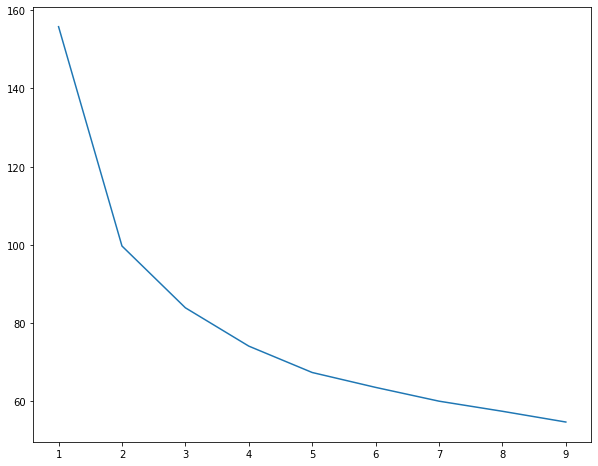

In [42]:
total_distance_arr = []
for i in range(1,10):
    kMean = KMeans(i)
    kMean.fit(df_MinMax)
    total_distance = kMean.inertia_
    total_distance_arr.append(total_distance)
    
plt.plot(range(1,10), total_distance_arr)

> Kết luận: Chọn k = 4 vì...

##### 5.1.2 Dendrogram (Hierarchical)

Chọn k = ?

In [43]:
def kMeans_clusters_func(data, k = 4): 
    km = KMeans(k)
    km.fit_predict(data)
    score = silhouette_score(data, km.labels_, metric='euclidean')
    return km.labels_, score


In [44]:
from sklearn.manifold import TSNE

for n_component in range(2,4):
    df_TSNE = pd.DataFrame(TSNE(n_components=n_component, random_state=1).fit_transform(df_MinMax))

    for k in range(2, 6):
      clusters, score = kMeans_clusters_func(df_TSNE, k)
      print(f"n = {n_component}, k = {k}, score = {score}")




print(score)


n = 2, k = 2, score = 0.5351558327674866
n = 2, k = 3, score = 0.4578951299190521
n = 2, k = 4, score = 0.4597978889942169
n = 2, k = 5, score = 0.41493749618530273
n = 3, k = 2, score = 0.43878304958343506
n = 3, k = 3, score = 0.38669002056121826
n = 3, k = 4, score = 0.3550201654434204
n = 3, k = 5, score = 0.32650646567344666
0.32650647


#### 5.2 Các thuật toán

##### 5.2.1 KMeans

##### 5.2.2 DBScan

##### 5.2.3 Hierarchical